# Latent Dirichlet Allocation for Text Data

In this assignment you will

* apply standard preprocessing techniques on Wikipedia text data
* fit a Latent Dirichlet allocation (LDA) model
* explore and interpret the results, including topic keywords and topic assignments for documents

Recall that a major feature distinguishing the LDA model from our previously explored methods is the notion of *mixed membership*. Throughout the course so far, our models have assumed that each data point belongs to a single cluster. k-means determines membership simply by shortest distance to the cluster center, and Gaussian mixture models suppose that each data point is drawn from one of their component mixture distributions. In many cases, though, it is more realistic to think of data as genuinely belonging to more than one cluster or category - for example, if we have a model for text data that includes both "Politics" and "World News" categories, then an article about a recent meeting of the United Nations should have membership in both categories rather than being forced into just one.

With this in mind, we will fit an LDA model to a corpus of Wikipedia articles and examine the results to analyze the impact of a mixed membership approach. In particular, we want to identify the topics discovered by the model in terms of their most important words, and we want to use the model to predict the topic membership distribution for a given document. 

## Text Data Preprocessing
We'll start by importing our familiar Wikipedia dataset.

In [1]:
!pip install nltk

     |████████████████████████████████| 1.5 MB 22.1 MB/s eta 0:00:01
     |████████████████████████████████| 758 kB 95.9 MB/s eta 0:00:01
You should consider upgrading via the '/opt/conda/bin/python3 -m pip install --upgrade pip' command.


In [56]:
import json
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix

import nltk
from nltk.corpus import stopwords
import random
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA

from sklearn.metrics.pairwise import euclidean_distances
from sklearn.neighbors import NearestNeighbors

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [251]:
# import wiki data
wiki = pd.read_csv('people_wiki.csv')
wiki

,URI,name,text
0,<http://dbpedia.org/resource/Digby_Morrell>,Digby Morrell,digby morrell born 10 october 1979 is a former...
1,<http://dbpedia.org/resource/Alfred_J._Lewy>,Alfred J. Lewy,alfred j lewy aka sandy lewy graduated from un...
2,<http://dbpedia.org/resource/Harpdog_Brown>,Harpdog Brown,harpdog brown is a singer and harmonica player...
3,<http://dbpedia.org/resource/Franz_Rottensteiner>,Franz Rottensteiner,franz rottensteiner born in waidmannsfeld lowe...
4,<http://dbpedia.org/resource/G-Enka>,G-Enka,henry krvits born 30 december 1974 in tallinn ...
...,...,...,...
59066,<http://dbpedia.org/resource/Olari_Elts>,Olari Elts,olari elts born april 27 1971 in tallinn eston...
59067,<http://dbpedia.org/resource/Scott_F._Crago>,Scott F. Crago,scott francis crago born july 26 1963 twin bro...
59068,<http://dbpedia.org/resource/David_Cass_(footb...,David Cass (footballer),david william royce cass born 27 march 1962 in...
59069,<http://dbpedia.org/resource/Keith_Elias>,Keith Elias,keith hector elias born february 3 1972 in lac...


In the original data, each Wikipedia article is represented by a URI, a name, and a string containing the entire text of the article. Recall from the video lectures that LDA requires documents to be represented as a _bag of words_, which ignores word ordering in the document but retains information on how many times each word appears. As we have seen in our previous encounters with text data, words such as 'the', 'a', or 'and' are by far the most frequent, but they appear so commonly in the English language that they tell us almost nothing about how similar or dissimilar two documents might be. 

Therefore, before we train our LDA model, we will preprocess the Wikipedia data in two steps: first, we will create a bag of words representation for each article, and then we will remove the common words that don't help us to distinguish between documents.

In [252]:
def load_sparse_csr(filename):
    loader = np.load(filename)
    data = loader['data']
    indices = loader['indices']
    indptr = loader['indptr']
    shape = loader['shape']
    
    return csr_matrix( (data, indices, indptr), shape)

word_count = load_sparse_csr('people_wiki_word_count.npz')

with open('people_wiki_map_index_to_word.json', 'r') as f:
    map_index_to_word = json.load(f)

In [253]:
def unpack_dict(matrix, map_index_to_word):
    table = sorted(map_index_to_word, key=map_index_to_word.get)    
    data = matrix.data
    indices = matrix.indices
    indptr = matrix.indptr
    
    num_doc = matrix.shape[0]

    return [{k:v for k,v in zip([table[word_id] for word_id in indices[indptr[i]:indptr[i+1]] ],
                                data[indptr[i]:indptr[i+1]].tolist())} \
            for i in range(num_doc) ]

wiki['word_count'] = unpack_dict(word_count, map_index_to_word)

In [254]:
# extract the words from the word count dictionary
wiki['words'] = wiki.word_count.apply(lambda x: list(x.keys()))
# remove English stopwords
stop_words = list(stopwords.words('english'))
wiki['clean_words'] = wiki.words.apply(lambda x: [w for w in x if w.lower() not in stop_words])

# turn the word lists back into text strings
wiki['clean_text'] = wiki.clean_words.apply(' '.join)
wiki.head()

,URI,name,text,word_count,words,clean_words,clean_text
0,<http://dbpedia.org/resource/Digby_Morrell>,Digby Morrell,digby morrell born 10 october 1979 is a former...,"{'brisbaneafter': 1, 'edflhe': 1, 'aflfrom': 1...","[brisbaneafter, edflhe, aflfrom, 44game, mcker...","[brisbaneafter, edflhe, aflfrom, 44game, mcker...",brisbaneafter edflhe aflfrom 44game mckernan m...
1,<http://dbpedia.org/resource/Alfred_J._Lewy>,Alfred J. Lewy,alfred j lewy aka sandy lewy graduated from un...,"{'maladaptation': 1, 'phasedelay': 1, '25hour'...","[maladaptation, phasedelay, 25hour, phaseadvan...","[maladaptation, phasedelay, 25hour, phaseadvan...",maladaptation phasedelay 25hour phaseadvance c...
2,<http://dbpedia.org/resource/Harpdog_Brown>,Harpdog Brown,harpdog brown is a singer and harmonica player...,"{'germanyover': 1, 'bluesgospel': 1, 'harpdog'...","[germanyover, bluesgospel, harpdog, surveybrow...","[germanyover, bluesgospel, harpdog, surveybrow...",germanyover bluesgospel harpdog surveybrown ju...
3,<http://dbpedia.org/resource/Franz_Rottensteiner>,Franz Rottensteiner,franz rottensteiner born in waidmannsfeld lowe...,"{'fantasticrottensteiner': 1, 'waidmannsfeld':...","[fantasticrottensteiner, waidmannsfeld, struga...","[fantasticrottensteiner, waidmannsfeld, struga...",fantasticrottensteiner waidmannsfeld strugatsk...
4,<http://dbpedia.org/resource/G-Enka>,G-Enka,henry krvits born 30 december 1974 in tallinn ...,"{'arhm': 3, 'gangstergenka': 1, 'kuhnja': 1, '...","[arhm, gangstergenka, kuhnja, palmisaar, produ...","[arhm, gangstergenka, kuhnja, palmisaar, produ...",arhm gangstergenka kuhnja palmisaar producerge...


In [255]:
# convert clean_text into a DTM
# take a subset of the data (otherwise it takes too long)
idx = random.sample(list(wiki.index), 20000)
wiki_small = wiki.loc[idx]

count_vec = CountVectorizer()
wiki_dtm = count_vec.fit_transform(wiki_small.clean_text)
wiki_dtm

<20000x257417 sparse matrix of type '<class 'numpy.int64'>'
	with 2900058 stored elements in Compressed Sparse Row format>

## Model fitting and interpretation
In the video lectures we saw that Gibbs sampling can be used to perform inference in the LDA model. In this assignment we will learn the topic model for our Wikipedia data, and our main emphasis will be on interpreting the results. We'll begin by creating the topic model.

In [256]:
%%time
topic_model = LDA(n_components=10, max_iter=50, n_jobs=-1, evaluate_every=-1, verbose=1, random_state=42,
                  doc_topic_prior=5, topic_word_prior=0.1)
model_matrix = topic_model.fit_transform(wiki_dtm)

iteration: 1 of max_iter: 50
iteration: 2 of max_iter: 50
iteration: 3 of max_iter: 50
iteration: 4 of max_iter: 50
iteration: 5 of max_iter: 50
iteration: 6 of max_iter: 50
iteration: 7 of max_iter: 50
iteration: 8 of max_iter: 50
iteration: 9 of max_iter: 50
iteration: 10 of max_iter: 50
iteration: 11 of max_iter: 50
iteration: 12 of max_iter: 50
iteration: 13 of max_iter: 50
iteration: 14 of max_iter: 50
iteration: 15 of max_iter: 50
iteration: 16 of max_iter: 50
iteration: 17 of max_iter: 50
iteration: 18 of max_iter: 50
iteration: 19 of max_iter: 50
iteration: 20 of max_iter: 50
iteration: 21 of max_iter: 50
iteration: 22 of max_iter: 50
iteration: 23 of max_iter: 50
iteration: 24 of max_iter: 50
iteration: 25 of max_iter: 50
iteration: 26 of max_iter: 50
iteration: 27 of max_iter: 50
iteration: 28 of max_iter: 50
iteration: 29 of max_iter: 50
iteration: 30 of max_iter: 50
iteration: 31 of max_iter: 50
iteration: 32 of max_iter: 50
iteration: 33 of max_iter: 50
iteration: 34 of ma

`sklearn` provides a useful summary of the model we have fitted, including the hyperparameter settings for alpha, gamma, K (the number of topics); the structure of the output data; and some useful methods for understanding the results.

In [257]:
topic_model

LatentDirichletAllocation(batch_size=128, doc_topic_prior=5, evaluate_every=-1,
                          learning_decay=0.7, learning_method='batch',
                          learning_offset=10.0, max_doc_update_iter=100,
                          max_iter=50, mean_change_tol=0.001, n_components=10,
                          n_jobs=-1, perp_tol=0.1, random_state=42,
                          topic_word_prior=0.1, total_samples=1000000.0,
                          verbose=1)

In [258]:
# alpha - how much each document "likes" each topic
print("alpha: " + str(topic_model.doc_topic_prior_))
# gamma - how much each topic "likes" a word
print("gamma: " + str(topic_model.topic_word_prior_))
# K - the number of topics
print("K: " + str(topic_model.components_.shape[0]))

alpha: 5
gamma: 0.1
K: 10


It is certainly useful to have pre-implemented methods available for LDA, but as with our previous methods for clustering and retrieval, implementing and fitting the model gets us only halfway towards our objective. We now need to analyze the fitted model to understand what it has done with our data and whether it will be useful as a document classification system. This can be a challenging task in itself, particularly when the model that we use is complex. We will begin by outlining a sequence of objectives that will help us understand our model in detail. In particular, we will

* get the top words in each topic and use these to identify topic themes
* predict topic distributions for some example documents
* compare the quality of LDA "nearest neighbors" to the NN output from the first assignment
* understand the role of model hyperparameters alpha and gamma

## Load a fitted topic model
The method used to fit the LDA model is a *randomized algorithm*, which means that it involves steps that are random; in this case, the randomness comes from Gibbs sampling, as discussed in the LDA video lectures. Because of these random steps, the algorithm will be expected to yield slighty different output for different runs on the same data - note that this is different from previously seen algorithms such as k-means or EM, which will always produce the same results given the same input and initialization.

It is important to understand that variation in the results is a fundamental feature of randomized methods. However, in the context of this assignment this variation makes it difficult to evaluate the correctness of your analysis, so we will load and analyze a pre-trained model. 

We recommend that you spend some time exploring your own fitted topic model and compare our analysis of the pre-trained model to the same analysis applied to the model you trained above.

In [12]:
# topic_model = turicreate.load_model('topic_models/lda_assignment_topic_model')

# Identifying topic themes by top words

We'll start by trying to identify the topics learned by our model with some major themes. As a preliminary check on the results of applying this method, it is reasonable to hope that the model has been able to learn topics that correspond to recognizable categories. In order to do this, we must first recall what exactly a 'topic' is in the context of LDA. 

In the video lectures on LDA we learned that a topic is a probability distribution over words in the vocabulary; that is, each topic assigns a particular probability to every one of the unique words that appears in our data. Different topics will assign different probabilities to the same word: for instance, a topic that ends up describing science and technology articles might place more probability on the word 'university' than a topic that describes sports or politics. Looking at the highest probability words in each topic will thus give us a sense of its major themes. Ideally we would find that each topic is identifiable with some clear theme _and_ that all the topics are relatively distinct.

We can use the `components_` attribute to view the topic words (along with their associated probabilities) from each topic.

In [259]:
terms = count_vec.get_feature_names()

for idx, component in enumerate(topic_model.components_):
    zipped = zip(terms, component)
    top_terms_key = sorted(zipped, key = lambda x: x[1], reverse=True)[:10]
    top_terms_list = list(dict(top_terms_key).keys())
    top_probs_list = [round(prob, 2) for prob in list(dict(top_terms_key).values())]
    print("Topic " + str(idx) + ": ", top_terms_list)
    print("Topic " + str(idx) + ": ", top_probs_list)    

Topic 0:  ['would', 'one', 'later', 'may', 'born', 'july', 'october', 'however', 'became', 'said']
Topic 0:  [1843.78, 1420.83, 1389.79, 1386.03, 1243.52, 1240.87, 1227.29, 1192.51, 1138.54, 1121.0]
Topic 1:  ['born', 'also', 'first', 'one', 'british', 'english', 'two', 'years', 'new', '2009']
Topic 1:  [3802.44, 3587.28, 3257.33, 2284.61, 2188.5, 2053.06, 2008.07, 1946.87, 1889.83, 1867.28]
Topic 2:  ['born', 'years', 'also', 'war', 'family', 'later', 'time', 'father', 'worked', 'first']
Topic 2:  [2394.02, 1487.11, 1310.91, 1186.93, 1150.39, 1145.6, 1083.77, 934.05, 915.45, 892.69]
Topic 3:  ['released', 'music', 'album', 'artist', 'known', 'band', 'records', 'art', 'name', 'artists']
Topic 3:  [2189.67, 1845.73, 1747.1, 1662.75, 1616.13, 1436.71, 1259.67, 1242.13, 1225.76, 1211.32]
Topic 4:  ['university', 'published', 'professor', 'work', 'american', 'research', 'book', 'received', 'books', 'institute']
Topic 4:  [4409.28, 2758.37, 2690.1, 2437.5, 2302.88, 2215.85, 2191.47, 2041.42

__Quiz Question:__ Identify the top 3 most probable words for the first topic.

would, one and later

**Quiz Question:** What is the sum of the probabilities assigned to the top 50 words in the 3rd topic?

In [260]:
component = topic_model.components_[2]
zipped = zip(terms, component)
top_terms_key = sorted(zipped, key = lambda x: x[1], reverse=True)[:50]
top_probs_list = list(dict(top_terms_key).values())

print(np.array(top_probs_list).sum())

35809.76247290716


Let's look at the top 10 words for each topic to see if we can identify any themes:

In [261]:
for idx, component in enumerate(topic_model.components_):
    zipped = zip(terms, component)
    top_terms_key = sorted(zipped, key = lambda x: x[1], reverse=True)[:10]
    top_terms_list = list(dict(top_terms_key).keys())
    top_probs_list = [round(prob, 2) for prob in list(dict(top_terms_key).values())]
    print("Topic " + str(idx) + ": ", top_terms_list)

Topic 0:  ['would', 'one', 'later', 'may', 'born', 'july', 'october', 'however', 'became', 'said']
Topic 1:  ['born', 'also', 'first', 'one', 'british', 'english', 'two', 'years', 'new', '2009']
Topic 2:  ['born', 'years', 'also', 'war', 'family', 'later', 'time', 'father', 'worked', 'first']
Topic 3:  ['released', 'music', 'album', 'artist', 'known', 'band', 'records', 'art', 'name', 'artists']
Topic 4:  ['university', 'published', 'professor', 'work', 'american', 'research', 'book', 'received', 'books', 'institute']
Topic 5:  ['born', 'also', 'music', 'de', 'studied', 'international', 'performed', 'new', 'including', 'performance']
Topic 6:  ['member', 'served', 'state', 'born', 'elected', 'former', 'party', 'school', 'university', 'law']
Topic 7:  ['team', 'played', 'career', 'season', 'professional', 'born', 'league', 'former', 'player', 'year']
Topic 8:  ['television', 'series', 'film', 'american', 'appeared', 'show', 'best', 'award', 'radio', 'also']
Topic 9:  ['director', 'inter

We propose the following themes for each topic:

- topic 0: Business
- topic 1: Science and research
- topic 2: International music
- topic 3: Art and publishing
- topic 4: Team sports
- topic 5: Family and society
- topic 6: Politics
- topic 7: International athletics
- topic 8: TV and film
- topic 9: General music

We'll save these themes for later:

In [270]:
themes = ['?1',
          'Britain',
          'family',
          'music',
          'research and academia',
          'performing arts',
          'politics',
          'sports',
          'TV, film and radio',
          'business']

### Measuring the importance of top words

We can learn more about topics by exploring how they place probability mass (which we can think of as a weight) on each of their top words.

We'll do this with two visualizations of the weights for the top words in each topic:
 - the weights of the top 100 words, sorted by the size
 - the total weight of the top 10 words


Here's a plot for the top 100 words by weight in each topic:

In [271]:
probs_lists = []
for idx, component in enumerate(topic_model.components_):
    zipped = zip(terms, component)
    top_terms_key = sorted(zipped, key = lambda x: x[1], reverse=True)[:100]
    top_probs_list = list(dict(top_terms_key).values())
    probs_lists.append(top_probs_list)

probs_df_wide = pd.DataFrame(probs_lists).transpose()
probs_df_wide.columns = ['topic 1', 'topic 2', 'topic 3', 'topic 4', 'topic 5', 'topic 6', 'topic 7',
                         'topic 8', 'topic 9', 'topic 10']
probs_df_wide.rename_axis(index='index', columns='topic', axis=1, inplace=True)
probs_df_wide.head()

probs_df = probs_df_wide.stack().reset_index(name='probability')
probs_df.sort_values(by=['topic', 'index'], inplace=True)
probs_df.columns = ['order', 'topic', 'probability']

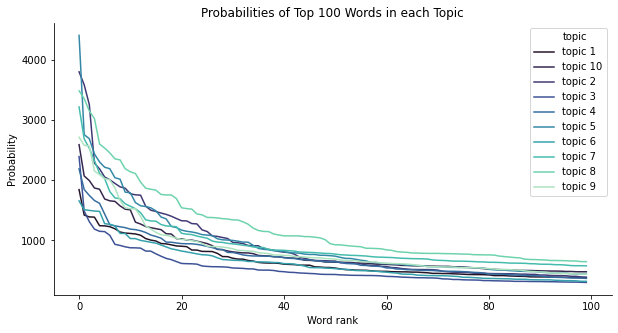

In [272]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.lineplot(data=probs_df, x='order', y='probability', hue='topic', palette='mako')
ax.set(xlabel='Word rank', ylabel='Probability', title='Probabilities of Top 100 Words in each Topic')
sns.despine();

In the above plot, each line corresponds to one of our ten topics. Notice how for each topic, the weights drop off sharply as we move down the ranked list of most important words. This shows that the top 10-20 words in each topic are assigned a much greater weight than the remaining words - and remember from the summary of our topic model that our vocabulary has 256303 words in total!


Next we plot the total weight assigned by each topic to its top 10 words: 

In [273]:
probs_sums = []
for idx, component in enumerate(topic_model.components_):
    zipped = zip(terms, component)
    top_terms_key = sorted(zipped, key = lambda x: x[1], reverse=True)[:10]
    top_probs_list = list(dict(top_terms_key).values())
    top_probs_sum = np.array(top_probs_list).sum()
    all_probs_sum = component.sum()
    
    probs_sums.append((top_probs_sum, all_probs_sum))
    
probs_df = pd.DataFrame(probs_sums)
probs_df.reset_index(inplace=True)
probs_df.columns = ['topic', 'top_terms', 'all_terms']
probs_df['proportion'] = probs_df.top_terms / probs_df.all_terms * 100

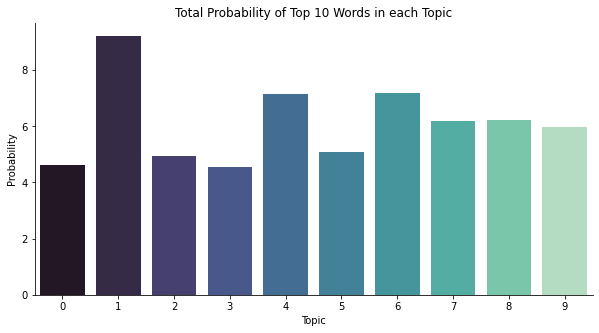

In [274]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(data=probs_df, x='topic', y='proportion', palette='mako')
ax.set(xlabel='Topic', ylabel='Probability', title='Total Probability of Top 10 Words in each Topic')
sns.despine()

Here we see that, for our topic model, the top 10 words only account for a small fraction of their topic's total probability mass. So while we can use the top words to identify broad themes for each topic, we should keep in mind that in reality these topics are more complex than a simple 10-word summary.

Finally, we observe that some 'junk' words appear highly rated in some topics despite our efforts to remove unhelpful words before fitting the model; for example, the word 'born' appears as a top 10 word in three different topics, but it doesn't help us describe these topics at all.

# Topic distributions for some example documents

As we noted in the introduction to this assignment, LDA allows for mixed membership, which means that each document can partially belong to several different topics. For each document, topic membership is expressed as a vector of weights that sum to one; the magnitude of each weight indicates the degree to which the document represents that particular topic.

We'll explore this in our fitted model by looking at the topic distributions for a few example Wikipedia articles from our data set. We should find that these articles have the highest weights on the topics whose themes are most relevant to the subject of the article - for example, we'd expect an article on a politician to place relatively high weight on topics related to government, while an article about an athlete should place higher weight on topics related to sports or competition.

Here we predict the topic distribution for the article on Barack Obama:

In [275]:
new_doc = wiki[wiki.name == "Barack Obama"]

dtm = count_vec.transform(new_doc.clean_text)
topic_dist = topic_model.transform(dtm)

dist_df = pd.DataFrame(data={'probability': topic_dist.T.flatten(), 'topic': themes})
dist_df.sort_values(by='probability', ascending=False, inplace=True)
dist_df.reset_index(inplace=True, drop=True)
dist_df.head(2)

,probability,topic
0,0.348551,politics
1,0.141113,?1


__Quiz Question:__ What is the topic most closely associated with the article about former US President George W. Bush? Use the average results from 100 topic predictions.

In [276]:
new_doc = wiki[wiki.name == "George W. Bush"]
dtm = count_vec.transform(new_doc.clean_text)
topic_dist = topic_model.transform(dtm)

dist_df = pd.DataFrame(data={'probability': topic_dist.T.flatten(), 'topic': themes})
dist_df.sort_values(by='probability', ascending=False, inplace=True)
dist_df.reset_index(inplace=True, drop=True)
dist_df.head(1)

,probability,topic
0,0.283779,politics


__Quiz Question:__ What are the top 3 topics corresponding to the article about English football (soccer) player Steven Gerrard?

In [277]:
new_doc = wiki[wiki.name == "Steven Gerrard"]
dtm = count_vec.transform(new_doc.clean_text)
topic_dist = topic_model.transform(dtm)

dist_df = pd.DataFrame(data={'probability': topic_dist.T.flatten(), 'topic': themes})
dist_df.sort_values(by='probability', ascending=False, inplace=True)
dist_df.reset_index(inplace=True, drop=True)
dist_df.head(3)

,probability,topic
0,0.471845,sports
1,0.148048,Britain
2,0.081990,?1


# Comparing LDA to nearest neighbors for document retrieval

So far we have found that our topic model has learned some coherent topics, we have explored these topics as probability distributions over a vocabulary, and we have seen how individual documents in our Wikipedia data set are assigned to these topics in a way that corresponds with our expectations. 

In this section, we will use the predicted topic distribution as a representation of each document, similar to how we have previously represented documents by word count or TF-IDF. This gives us a way of computing distances between documents, so that we can run a nearest neighbors search for a given document based on its membership in the topics that we learned from LDA. We can contrast the results with those obtained by running nearest neighbors under the usual TF-IDF representation, an approach that we explored in a previous assignment. 

We'll start by creating the LDA topic distribution representation for each document:

In [278]:
new_dtm = count_vec.transform(wiki.clean_text)
new_topic_dist = topic_model.transform(new_dtm)

Next we add the TF-IDF document representations:

In [279]:
tfidf_vec = TfidfVectorizer()
wiki_tfidf_dtm = tfidf_vec.fit_transform(wiki.clean_text)

For each of our two different document representations, we can use `sklearn` to compute a brute-force nearest neighbors model:

In [280]:
model_tfidf = NearestNeighbors(algorithm='brute', metric='cosine', n_jobs=-1)
model_tfidf.fit(wiki_tfidf_dtm)

model_lda_rep = NearestNeighbors(algorithm='brute', metric='cosine', n_jobs=-1)
model_lda_rep.fit(new_topic_dist)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=-1, n_neighbors=5, p=2, radius=1.0)

Let's compare these nearest neighbor models by finding the nearest neighbors under each representation on an example document. For this example we'll use Paul Krugman, an American economist:

In [281]:
wiki[wiki['name'] == 'Paul Krugman']

,URI,name,text,word_count,words,clean_words,clean_text
4001,<http://dbpedia.org/resource/Paul_Krugman>,Paul Krugman,paul robin krugman born february 28 1953 is an...,"{'krugmans': 1, 'serviceskrugman': 1, 'timesfo...","[krugmans, serviceskrugman, timesfortune, slat...","[krugmans, serviceskrugman, timesfortune, slat...",krugmans serviceskrugman timesfortune slateas ...


In [282]:
distances, indices = model_tfidf.kneighbors(wiki_tfidf_dtm[4001], n_neighbors=10)
neighbours = pd.DataFrame({'distance':distances.flatten(), 'id':indices.flatten()})
neighbours.set_index('id').join(wiki).reset_index().sort_values('distance')[['id', 'name', 'distance']]

,id,name,distance
0,4001,Paul Krugman,0.000000
1,40686,Daniel Kahneman,0.886498
2,42353,Elise Brezis,0.888683
3,41608,John A. List,0.895838
4,22732,Sophie Meunier,0.896992
5,45216,Branko Milanovi%C4%87,0.897815
6,13233,Bruno Frey,0.898801
7,17915,Charles Horioka,0.899708
8,32000,Herbert Grubel,0.902857
9,29567,Markos Mamalakis,0.904031


In [283]:
distances, indices = model_lda_rep.kneighbors(new_topic_dist[4001].reshape(1,-1), n_neighbors=10)
neighbours = pd.DataFrame({'distance':distances.flatten(), 'id':indices.flatten()})
neighbours.set_index('id').join(wiki).reset_index().sort_values('distance')[['id', 'name', 'distance']]

,id,name,distance
0,4001,Paul Krugman,0.000000
1,9528,Peter Suedfeld,0.001704
2,47608,Victoria Bellotti,0.002283
3,2272,Mark Chignell,0.002817
4,11303,Steven Weinberg,0.002973
5,6103,Larry L. Peterson,0.003113
6,11687,Antonio Gotto,0.003278
7,18531,George Annas,0.003283
8,43864,Stephen Barr,0.003318
9,31314,Diane F. Halpern,0.003324


Notice that that there is no overlap between the two sets of top 10 nearest neighbors. This doesn't necessarily mean that one representation is better or worse than the other, but rather that they are picking out different features of the documents. 

With TF-IDF, documents are distinguished by the frequency of uncommon words. Since similarity is defined based on the specific words used in the document, documents that are "close" under TF-IDF tend to be similar in terms of specific details. This is what we see in the example: the top 10 nearest neighbors are all economists from the US, UK, or Canada. 

Our LDA representation, on the other hand, defines similarity between documents in terms of their topic distributions. This means that documents can be "close" if they share similar themes, even though they may not share many of the same keywords. For the article on Paul Krugman, we expect the most important topics to be 'American college and politics' and 'science and research'. As a result, we see that the top 10 nearest neighbors are academics from a wide variety of fields, including literature, anthropology, and religious studies.

# Understanding the role of LDA model hyperparameters

Finally, we'll take a look at the effect of the LDA model hyperparameters alpha and gamma on the characteristics of our fitted model. Recall that alpha is a parameter of the prior distribution over topic weights in each document, while gamma is a parameter of the prior distribution over word weights in each topic. 

In the video lectures, we saw that alpha and gamma can be thought of as smoothing parameters when we compute how much each document "likes" a topic (in the case of alpha) or how much each topic "likes" a word (in the case of gamma). In both cases, these parameters serve to reduce the differences across topics or words in terms of these calculated preferences; alpha makes the document preferences "smoother" over topics, and gamma makes the topic preferences "smoother" over words.

Our goal in this section will be to understand how changing these parameter values affects the characteristics of the resulting topic model.

__Quiz Question:__ What was the value of alpha used to fit our original topic model?

In [284]:
topic_model.doc_topic_prior_

5

__Quiz Question:__ What was the value of gamma used to fit our original topic model?

In [285]:
topic_model.topic_word_prior_

0.1

We'll start by loading some topic models that have been trained using different settings of alpha and gamma. Specifically, we will start by comparing the following two models to our original topic model:
 - tpm_low_alpha, a model trained with alpha = 1 and default gamma
 - tpm_high_alpha, a model trained with alpha = 50 and default gamma

In [286]:
%%time
tpm_low_alpha = LDA(n_components=10, max_iter=50, n_jobs=-1, evaluate_every=-1, verbose=1, random_state=42,
                    doc_topic_prior=1)
low_alpha_matrix = tpm_low_alpha.fit_transform(wiki_dtm)

tpm_high_alpha = LDA(n_components=10, max_iter=50, n_jobs=-1, evaluate_every=-1, verbose=1, random_state=42,
                     doc_topic_prior=50)
high_alpha_matrix = tpm_high_alpha.fit_transform(wiki_dtm)

iteration: 1 of max_iter: 50
iteration: 2 of max_iter: 50
iteration: 3 of max_iter: 50
iteration: 4 of max_iter: 50
iteration: 5 of max_iter: 50
iteration: 6 of max_iter: 50
iteration: 7 of max_iter: 50
iteration: 8 of max_iter: 50
iteration: 9 of max_iter: 50
iteration: 10 of max_iter: 50
iteration: 11 of max_iter: 50
iteration: 12 of max_iter: 50
iteration: 13 of max_iter: 50
iteration: 14 of max_iter: 50
iteration: 15 of max_iter: 50
iteration: 16 of max_iter: 50
iteration: 17 of max_iter: 50
iteration: 18 of max_iter: 50
iteration: 19 of max_iter: 50
iteration: 20 of max_iter: 50
iteration: 21 of max_iter: 50
iteration: 22 of max_iter: 50
iteration: 23 of max_iter: 50
iteration: 24 of max_iter: 50
iteration: 25 of max_iter: 50
iteration: 26 of max_iter: 50
iteration: 27 of max_iter: 50
iteration: 28 of max_iter: 50
iteration: 29 of max_iter: 50
iteration: 30 of max_iter: 50
iteration: 31 of max_iter: 50
iteration: 32 of max_iter: 50
iteration: 33 of max_iter: 50
iteration: 34 of ma

In [287]:
# tpm_low_alpha = turicreate.load_model('topic_models/lda_low_alpha')
# tpm_high_alpha = turicreate.load_model('topic_models/lda_high_alpha')

### Changing the hyperparameter alpha

Since alpha is responsible for smoothing document preferences over topics, the impact of changing its value should be visible when we plot the distribution of topic weights for the same document under models fit with different alpha values. In the code below, we plot the (sorted) topic weights for the Wikipedia article on Barack Obama under models fit with high, original, and low settings of alpha.

In [288]:
# re-do as initial applicable vectoriser was overwritten
count_vec = CountVectorizer()
wiki_dtm = count_vec.fit_transform(wiki_small.clean_text)

In [289]:
new_doc = wiki[wiki.name == "Barack Obama"]
dtm = count_vec.transform(new_doc.clean_text)

high_alpha_dist = tpm_high_alpha.transform(dtm).flatten()
original_dist = topic_model.transform(dtm).flatten()
low_alpha_dist = tpm_low_alpha.transform(dtm).flatten()

dist_df = pd.DataFrame(data={'topic': themes, 'original': original_dist, 'high': high_alpha_dist, 'low': low_alpha_dist})
dist_df.sort_values(by='original', inplace=True, ascending=False)
dist_df = pd.melt(dist_df, id_vars='topic', var_name='model', value_name='probability')
dist_df.head()

,topic,model,probability
0,politics,original,0.348551
1,?1,original,0.141113
2,business,original,0.125943
3,family,original,0.106211
4,research and academia,original,0.089569


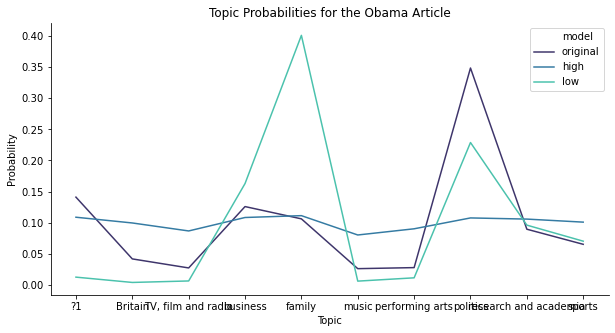

In [290]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.lineplot(data=dist_df, x='topic', y='probability', hue='model', palette='mako')
ax.set(xlabel='Topic', ylabel='Probability', title='Topic Probabilities for the Obama Article')
sns.despine();

Here we can clearly see the smoothing enforced by the alpha parameter - notice that when alpha is low most of the weight in the topic distribution for this article goes to a single topic, but when alpha is high the weight is much more evenly distributed across the topics.

__Quiz Question:__ How many topics are assigned a weight greater than 0.3 or less than 0.05 for the article on Paul Krugman in the **low alpha** model? All but one.

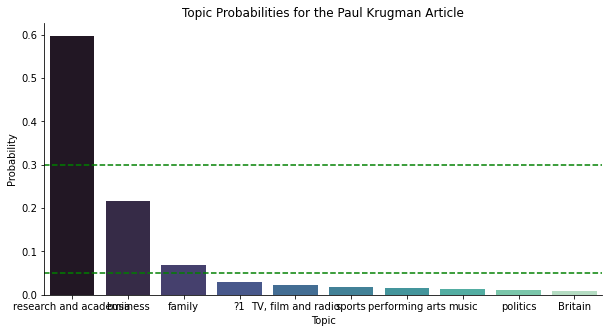

In [291]:
new_doc = wiki[wiki.name == "Paul Krugman"]
dtm = count_vec.transform(new_doc.clean_text)

low_alpha_dist = tpm_low_alpha.transform(dtm).flatten()

dist_df = pd.DataFrame(data={'topic': themes, 'probability': low_alpha_dist})
dist_df.sort_values(by='probability', inplace=True, ascending=False)
dist_df.head()

fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(data=dist_df, x='topic', y='probability', palette='mako')
plt.axhline(y=0.3, color='g', linestyle='--')
plt.axhline(y=0.05, color='g', linestyle='--')
ax.set(xlabel='Topic', ylabel='Probability', title='Topic Probabilities for the Paul Krugman Article')
sns.despine();

__Quiz Question:__ How many topics are assigned a weight greater than 0.3 or less than 0.05 for the article on Paul Krugman in the **high alpha** model? None.

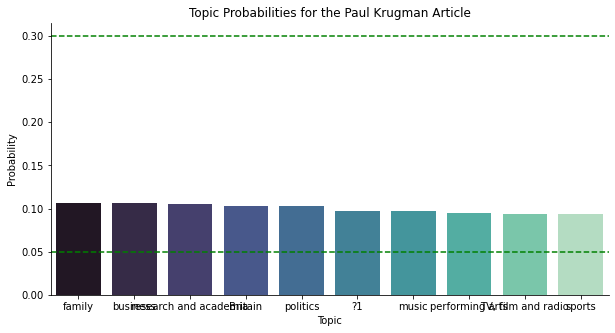

In [292]:
new_doc = wiki[wiki.name == "Paul Krugman"]
dtm = count_vec.transform(new_doc.clean_text)

high_alpha_dist = tpm_high_alpha.transform(dtm).flatten()

dist_df = pd.DataFrame(data={'topic': themes, 'probability': high_alpha_dist})
dist_df.sort_values(by='probability', inplace=True, ascending=False)
dist_df.head()

fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(data=dist_df, x='topic', y='probability', palette='mako')
plt.axhline(y=0.3, color='g', linestyle='--')
plt.axhline(y=0.05, color='g', linestyle='--')
ax.set(xlabel='Topic', ylabel='Probability', title='Topic Probabilities for the Paul Krugman Article')
sns.despine();

### Changing the hyperparameter gamma

Just as we were able to see the effect of alpha by plotting topic weights for a document, we expect to be able to visualize the impact of changing gamma by plotting word weights for each topic. In this case, however, there are far too many words in our vocabulary to do this effectively. Instead, we'll plot the total weight of the top 100 words and bottom 1000 words for each topic. Below, we plot the (sorted) total weights of the top 100 words and bottom 1000 from each topic in the high, original, and low gamma models.

Now we will consider the following two models:
 - tpm_low_gamma, a model trained with gamma = 0.02 and default alpha
 - tpm_high_gamma, a model trained with gamma = 0.5 and default alpha

In [151]:
%%time
tpm_low_gamma = LDA(n_components=10, max_iter=50, n_jobs=-1, evaluate_every=-1, verbose=1, random_state=42,
                    topic_word_prior=0.02)
low_gamma_matrix = tpm_low_gamma.fit_transform(wiki_dtm)

tpm_high_gamma = LDA(n_components=10, max_iter=50, n_jobs=-1, evaluate_every=-1, verbose=1, random_state=42,
                     topic_word_prior=0.5)
high_gamma_matrix = tpm_high_gamma.fit_transform(wiki_dtm)

iteration: 1 of max_iter: 50
iteration: 2 of max_iter: 50
iteration: 3 of max_iter: 50
iteration: 4 of max_iter: 50
iteration: 5 of max_iter: 50
iteration: 6 of max_iter: 50
iteration: 7 of max_iter: 50
iteration: 8 of max_iter: 50
iteration: 9 of max_iter: 50
iteration: 10 of max_iter: 50
iteration: 11 of max_iter: 50
iteration: 12 of max_iter: 50
iteration: 13 of max_iter: 50
iteration: 14 of max_iter: 50
iteration: 15 of max_iter: 50
iteration: 16 of max_iter: 50
iteration: 17 of max_iter: 50
iteration: 18 of max_iter: 50
iteration: 19 of max_iter: 50
iteration: 20 of max_iter: 50
iteration: 21 of max_iter: 50
iteration: 22 of max_iter: 50
iteration: 23 of max_iter: 50
iteration: 24 of max_iter: 50
iteration: 25 of max_iter: 50
iteration: 26 of max_iter: 50
iteration: 27 of max_iter: 50
iteration: 28 of max_iter: 50
iteration: 29 of max_iter: 50
iteration: 30 of max_iter: 50
iteration: 31 of max_iter: 50
iteration: 32 of max_iter: 50
iteration: 33 of max_iter: 50
iteration: 34 of ma

Instead, we'll plot the total weight of the top 100 words and bottom 1000 words for each topic. Below, we plot the (sorted) total weights of the top 100 words and bottom 1000 from each topic in the high, original, and low gamma models.

In [208]:
terms = count_vec.get_feature_names()

top_probs_sums = []
for idx, component in enumerate(topic_model.components_):
    zipped = zip(terms, component)
    top_terms_key = sorted(zipped, key = lambda x: x[1], reverse=True)[:100]
    top_probs_list = list(dict(top_terms_key).values())
    top_probs_sum = np.array(top_probs_list).sum()

    top_probs_sums.append(top_probs_sum)

bottom_probs_sums = []
for idx, component in enumerate(topic_model.components_):
    zipped = zip(terms, component)    
    bottom_terms_key = sorted(zipped, key = lambda x: x[1], reverse=True)[-1000:]
    bottom_probs_list = list(dict(bottom_terms_key).values())
    bottom_probs_sum = np.array(bottom_probs_list).sum()
    all_probs_sum = component.sum()
    
    bottom_probs_sums.append((bottom_probs_sum, all_probs_sum))
    
probs_df = pd.DataFrame(top_probs_sums, columns = ['top_terms'])
probs_df2 = pd.DataFrame(bottom_probs_sums, columns = ['bottom_terms', 'all_terms'])
probs_df = pd.concat([probs_df, probs_df2], axis=1)
probs_df.reset_index(inplace=True)
probs_df.columns = ['topic', 'top_terms', 'bottom_terms', 'all_terms']
probs_df['top_prop'] = probs_df.top_terms / probs_df.all_terms * 100
probs_df['bottom_prop'] = probs_df.bottom_terms / probs_df.all_terms * 100
probs_df['model'] = 'original'
original_probs_df = probs_df.copy()

In [209]:
top_probs_sums = []
for idx, component in enumerate(tpm_low_gamma.components_):
    zipped = zip(terms, component)
    top_terms_key = sorted(zipped, key = lambda x: x[1], reverse=True)[:100]
    top_probs_list = list(dict(top_terms_key).values())
    top_probs_sum = np.array(top_probs_list).sum()

    top_probs_sums.append(top_probs_sum)

bottom_probs_sums = []
for idx, component in enumerate(tpm_low_gamma.components_):
    zipped = zip(terms, component)    
    bottom_terms_key = sorted(zipped, key = lambda x: x[1], reverse=True)[-1000:]
    bottom_probs_list = list(dict(bottom_terms_key).values())
    bottom_probs_sum = np.array(bottom_probs_list).sum()
    all_probs_sum = component.sum()
    
    bottom_probs_sums.append((bottom_probs_sum, all_probs_sum))
    
probs_df = pd.DataFrame(top_probs_sums, columns = ['top_terms'])
probs_df2 = pd.DataFrame(bottom_probs_sums, columns = ['bottom_terms', 'all_terms'])
probs_df = pd.concat([probs_df, probs_df2], axis=1)
probs_df.reset_index(inplace=True)
probs_df.columns = ['topic', 'top_terms', 'bottom_terms', 'all_terms']
probs_df['top_prop'] = probs_df.top_terms / probs_df.all_terms * 100
probs_df['bottom_prop'] = probs_df.bottom_terms / probs_df.all_terms * 100
probs_df['model'] = 'low_gamma'
low_probs_df = probs_df.copy()

In [210]:
top_probs_sums = []
for idx, component in enumerate(tpm_high_gamma.components_):
    zipped = zip(terms, component)
    top_terms_key = sorted(zipped, key = lambda x: x[1], reverse=True)[:100]
    top_probs_list = list(dict(top_terms_key).values())
    top_probs_sum = np.array(top_probs_list).sum()

    top_probs_sums.append(top_probs_sum)

bottom_probs_sums = []
for idx, component in enumerate(tpm_high_gamma.components_):
    zipped = zip(terms, component)    
    bottom_terms_key = sorted(zipped, key = lambda x: x[1], reverse=True)[-1000:]
    bottom_probs_list = list(dict(bottom_terms_key).values())
    bottom_probs_sum = np.array(bottom_probs_list).sum()
    all_probs_sum = component.sum()
    
    bottom_probs_sums.append((bottom_probs_sum, all_probs_sum))
    
probs_df = pd.DataFrame(top_probs_sums, columns = ['top_terms'])
probs_df2 = pd.DataFrame(bottom_probs_sums, columns = ['bottom_terms', 'all_terms'])
probs_df = pd.concat([probs_df, probs_df2], axis=1)
probs_df.reset_index(inplace=True)
probs_df.columns = ['topic', 'top_terms', 'bottom_terms', 'all_terms']
probs_df['top_prop'] = probs_df.top_terms / probs_df.all_terms * 100
probs_df['bottom_prop'] = probs_df.bottom_terms / probs_df.all_terms * 100
probs_df['model'] = 'high_gamma'
high_probs_df = probs_df.copy()

In [214]:
probs_df = pd.concat([original_probs_df, low_probs_df, high_probs_df])
probs_df.head()

,topic,top_terms,bottom_terms,all_terms,top_prop,bottom_prop,model
0,0,13589.260972,100.0,79071.416892,17.186060,0.126468,original
1,1,117072.504730,100.0,611801.907177,19.135688,0.016345,original
2,2,574.925109,100.0,48662.279185,1.181459,0.205498,original
3,3,134218.902148,100.0,710283.169839,18.896534,0.014079,original
4,4,128825.710611,100.0,553474.373058,23.275822,0.018068,original


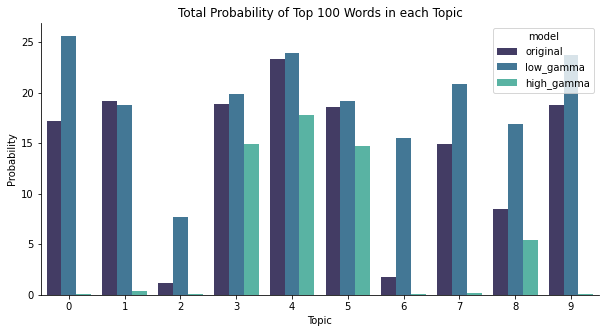

In [220]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(data=probs_df, x="topic", y="top_prop", hue="model", palette="mako")
ax.set(xlabel='Topic', ylabel='Probability', title='Total Probability of Top 100 Words in each Topic')
sns.despine();

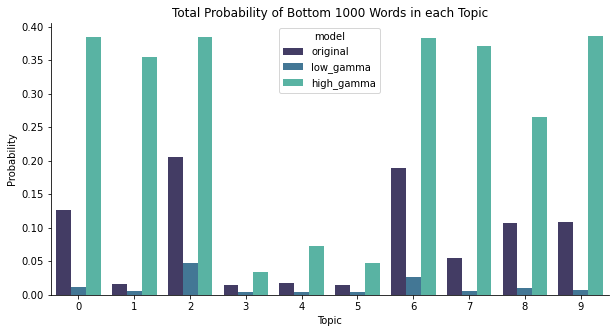

In [221]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(data=probs_df, x="topic", y="bottom_prop", hue="model", palette="mako")
ax.set(xlabel='Topic', ylabel='Probability', title='Total Probability of Bottom 1000 Words in each Topic')
sns.despine();

From these two plots we can see that the low gamma model results in higher weight placed on the top words and lower weight placed on the bottom words for each topic, while the high gamma model places relatively less weight on the top words and more weight on the bottom words. Thus increasing gamma results in topics that have a smoother distribution of weight across all the words in the vocabulary.

__Quiz Question:__ For each topic of the **low gamma model**, compute the number of words required to make a list with total probability 0.5. What is the average number of words required across all topics? 1,525

In [293]:
%%time
num_words_lst = []
for idx, component in enumerate(tpm_low_gamma.components_):
    num_words = 0
    probability = 0
    
    while probability < 0.5:
        zipped = zip(terms, component)
        terms_key = sorted(zipped, key = lambda x: x[1], reverse=True)[:num_words]
        probs_list = list(dict(terms_key).values())
        probs_sum = np.array(probs_list).sum()
        all_probs_sum = component.sum()
        probability = probs_sum / all_probs_sum
    
        if probability >= 0.5:
            num_words_lst.append((num_words, probability))
        else:
            num_words += 50

CPU times: user 1min 9s, sys: 115 ms, total: 1min 9s
Wall time: 1min 9s


In [294]:
words_df = pd.DataFrame(num_words_lst)
words_df.reset_index(inplace=True)
words_df.columns = ['topic', 'num_words', 'probability']

avg_words = words_df.num_words.mean()
avg_words

1525.0

__Quiz Question:__ For each topic of the **high gamma model**, compute the number of words required to make a list with total probability 0.5. What is the average number of words required across all topics? 82,800

In [295]:
%%time
num_words_lst = []
for idx, component in enumerate(tpm_high_gamma.components_):
    num_words = 0
    probability = 0
    
    while probability < 0.5:
        zipped = zip(terms, component)
        terms_key = sorted(zipped, key = lambda x: x[1], reverse=True)[:num_words]
        probs_list = list(dict(terms_key).values())
        probs_sum = np.array(probs_list).sum()
        all_probs_sum = component.sum()
        probability = probs_sum / all_probs_sum
    
        if probability >= 0.5:
            num_words_lst.append((num_words, probability))
        else:
            # the number of words required for this model is high
            num_words += 1000

CPU times: user 5min 47s, sys: 143 ms, total: 5min 48s
Wall time: 5min 48s


In [296]:
words_df = pd.DataFrame(num_words_lst)
words_df.reset_index(inplace=True)
words_df.columns = ['topic', 'num_words', 'probability']

avg_words = words_df.num_words.mean()
avg_words

82800.0

We have now seen how the hyperparameters alpha and gamma influence the characteristics of our LDA topic model, but we haven't said anything about what settings of alpha or gamma are best. We know that these parameters are responsible for controlling the smoothness of the topic distributions for documents and word distributions for topics, but there's no simple conversion between smoothness of these distributions and quality of the topic model. In reality, there is no universally "best" choice for these parameters. Instead, finding a good topic model requires that we be able to both explore the output (as we did by looking at the topics and checking some topic predictions for documents) and understand the impact of hyperparameter settings (as we have in this section).